# Обработка текстов

В этом ноутбуке проведем анализ текстовых комментариев к протоколам с использованием "интонационного" анализа.

Вопрос, на который отвечали учителя, заполняя каждый протокол, был следующим:  
**Выводы и идеи (Вы удовлетворены? Нужно ли что-то изменить? Какую достижимую цель вы хотели бы себе поставить? Понимаете ли вы, как ее достичь?)**

В большей части протоколов ответ на этот вопрос зафиксирован, но некоторые учителя оставили этот вопрос без ответа.

В первом полугодии 2022 года учителя фиксировали в протоколах только текстовые оценки проведенного урока, давая ответ на этот вопрос. Во втором полугодии начали использоваться доработанные протоколы, в которые были добавлены еще два вопроса, которые позволили зафиксировать степень удовлетворенности уроком.

Формулировки вопросов были следующими:
- **Удовлетворенность уроком** (варианты ответа: Да, Скорее да, Скорее нет, Нет)
- **Нужно ли что-то изменить** (варианты ответа: Да, Скорее да, Скорее нет, Нет)

В основном датафрейме проекта ответы на первый вопрос с текстовым значением хранятся в поле **teacher_comments**
Ответы на второй и третий вопросы - в полях **satisfaction**, **wish_to_change**.

В рамках этой части исследования попробуем научиться оценивать ответы на второй и третий вопросы при условии, что в протоколе присутствует текстовый комментарий учителя.

Помимо предсказания этих оценок попробуем также использовать внешнюю оценку с привлечением экспертов.

Есть также одно замечание по поводу текстовых комментариев. Хотя "по правилам игры" предполагалось, что этот комментарий будет писать учитель, который проводил урок, по факту часто это поле заполнял учитель, который проводил наблюдение. Это вносит в данные дополнительный "шум", увы.

1. Загрузка библиотек
2. Загрузка данных
3. Формирование выборки с полными данными
4. Формирование верификационной выборки из 200 текстовых комментариев (для экспертной оценки)

5. Формирование обучающей и тестовой выборок
6. Модель для предсказания степени удовлетворенности
7. Модель для предсказания степени желания что-то изменить

___
### 1. Загрузка библиотек

In [33]:
%run "./lib/load_big_libs.py"

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
%run "./lib/data_lib.py"

___
### 2. Загружаем полный датафрейм

In [4]:
df_full = pd.read_csv("data/intermid/full_df_extended.csv", sep=';')
df_full.head()

,Unnamed: 0,prot_id,template_code,date_of_lesson,org_id,teacher_id,observer_id,curator_id,class,satisfaction,...,scope,pupils_m,pupils_d,attention_m,attention_d,interactions_m,interactions_d,vector_interact,vector_intention,vector_attention
0,0,816,П1.1,01.02.2022,133,726,725,724,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1162,П1.1,02.02.2022,128,736,735,734,NaN,NaN,...,0.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1170,П1.1,02.02.2022,128,735,736,734,NaN,NaN,...,0.818182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1069,П1.1,04.02.2022,133,725,726,724,NaN,NaN,...,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,295,П1.1,07.02.2022,79,534,533,532,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_full[['prot_id', 'teacher_comments','satisfaction', 'wish_to_change']].describe()

,prot_id,satisfaction,wish_to_change
count,3001.000000,1016.000000,952.000000
mean,1579.222926,3.485236,2.161765
std,890.060019,0.633839,0.972324
min,41.000000,1.000000,1.000000
25%,805.000000,3.000000,1.000000
50%,1575.000000,4.000000,2.000000
75%,2356.000000,4.000000,3.000000
max,3115.000000,4.000000,4.000000


___
### 3. Формирование полной выборки

Отбираем все протоколы, в которых присутствует текстовый комментарий учителя.

Оставляем в нем только интересующие нас колонки:
- prot_id
- satisfaction
- wish_to_change
- teacher_comment

In [18]:
df_texts = df_full[df_full['teacher_comments'].str.len() > 0][['prot_id', 'satisfaction', 'wish_to_change', 'teacher_comments']].copy()
df_texts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2890 entries, 0 to 3000
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   prot_id           2890 non-null   int64  
 1   satisfaction      989 non-null    float64
 2   wish_to_change    927 non-null    float64
 3   teacher_comments  2890 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 112.9+ KB


In [19]:
df_texts

,prot_id,satisfaction,wish_to_change,teacher_comments
0,816,NaN,NaN,Больше внимания уделять слабым ученикам и моти...
1,1162,NaN,NaN,Учитель уделяет внимание всем учащимся
2,1170,NaN,NaN,"Уделять внимание не только тем, кто поднимает ..."
3,1069,NaN,NaN,Больше внимания уделять слабым ученикам и моти...
4,295,NaN,NaN,Своё внимание учитель распределял на всех обу...
...,...,...,...,...
2996,2935,4.0,1.0,"Удовлетворена. Был урок русского языка, повтор..."
2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...
2998,2745,3.0,2.0,"Уроком удовлетворена, но не всегда довольна те..."
2999,3090,4.0,1.0,"Уроком удовлетворена, так как старалась, чтобы..."


___
### 4. Формируем верификационную выборку из 200 записей
В выборку должны попасть как те записи, в которых поля satisfaction и wish_to_change содержат какие-то значения, так и те, где значения этих полей не определены.

In [20]:
# Формируем случайным образом выборку в 200 записей
df_sample42_200 = df_texts.sample(n=200, random_state=42)
df_sample42_200.to_csv('data/intermid/sample42_200.csv', ';')

In [29]:
# Сразу же получаем полную выборку МИНУС верификационная выборка
df_texts_work = df_texts[~df_texts['prot_id'].isin(set(df_sample42_200['prot_id'].tolist()))]
df_texts_work.describe()

,prot_id,satisfaction,wish_to_change
count,2690.000000,919.000000,859.000000
mean,1577.262454,3.479869,2.190920
std,892.586295,0.637753,0.973237
min,42.000000,1.000000,1.000000
25%,795.750000,3.000000,1.000000
50%,1575.500000,4.000000,2.000000
75%,2357.750000,4.000000,3.000000
max,3115.000000,4.000000,4.000000


### 5. Формирование обучающих и тестовых выборок
Поскольку мы будем формировать отдельные модели для предсказания удовлетворенности и для желания что-то изменить, для каждой из моделей сформируем отдельные датафреймы.
Префикс S будем использовать для удовлетворенности (satisfaction), W - для желания что-то изменить (wish_to_change)

#### 5.1. Формируем выборки для работы с параметром «Удовлетворение от проведенного урока»

In [30]:
df_texts_S = df_texts[~df_texts['satisfaction'].isnull()][['prot_id', 'teacher_comments', 'satisfaction']]
df_texts_S.describe()

,prot_id,satisfaction
count,989.000000,989.000000
mean,2473.592518,3.479272
std,386.272707,0.635350
min,80.000000,1.000000
25%,2174.000000,3.000000
50%,2497.000000,4.000000
75%,2803.000000,4.000000
max,3107.000000,4.000000


In [98]:
# Будем считать, что вместо четырех уровней степени удовлетворения нас утроят 2. Варианты Да и Скорее да = это 1, Варианты Нет и Скорее нет - это 0
df_texts_S['y'] = df_texts_S['satisfaction'].apply(lambda x: 0 if x < 4 else 1)
df_texts_S['y'].value_counts()

1    542
0    447
Name: y, dtype: int64

In [99]:
x_train_S, x_test_S, y_train_S, y_test_S = train_test_split(df_texts_S['teacher_comments'], df_texts_S['y'], test_size=0.33, random_state=42)

In [100]:
print(f'Количество строк в обучающей выборке: {x_train_S.count()}')
x_train_S[:10]

Количество строк в обучающей выборке: 662


2350    Учитель старается  на уроках   развивать речь ...
1896    Удовлетворен.Сформировать прочные навыки.Включ...
2332    Считаю, что учитель тактично и умело подбирает...
2136    На уроке наметился прогресс: начали работать с...
1927    удовлетворена уроком. Цель была достигнута. Ис...
1005         Уроком удовлетворена. Ничего менять не надо.
793                                Частично удовлетворена
2512                  Уроком удовлетворен. Нет,не нужно .
2071    Уроком удовлетворена.  Обучающие стали активне...
2872             Больше уделять внимание слабым ученикам.
Name: teacher_comments, dtype: object

#### 5.2. Формируем выборки для работы с параметром «Желание что-то изменить»

In [39]:
df_texts_W = df_texts[~df_texts['wish_to_change'].isnull()][['prot_id', 'teacher_comments', 'wish_to_change']]
df_texts_W.describe()

,prot_id,wish_to_change
count,927.000000,927.000000
mean,2499.871629,2.179072
std,371.559988,0.969444
min,1734.000000,1.000000
25%,2216.500000,1.000000
50%,2520.000000,2.000000
75%,2817.500000,3.000000
max,3107.000000,4.000000


In [41]:
# Будем считать, что вместо четырех уровней степени желания нас утроят 2. Варианты Да и Скорее да = это 1, Варианты Нет и Скорее нет - это 0
df_texts_W['y'] = df_texts_W['wish_to_change'].apply(lambda x: 0 if x < 3 else 1)
df_texts_W['y'].value_counts()

0    602
1    325
Name: y, dtype: int64

In [42]:
x_train_W, x_test_W, y_train_W, y_test_W = train_test_split(df_texts_W['teacher_comments'], df_texts_W['y'], test_size=0.33, random_state=42)

In [45]:
print(f'Количество строк в обучающей выборке: {x_train_W.count()}')
x_train_W[:10]

Количество строк в обучающей выборке: 621


381     Уроком удовлетворена. Внимание распределено ме...
2377    Уроком удовлетворена. Если сравнивать с предыд...
1344    Уроком удовлетворена. На репродуктивные вопрос...
1932    Уроком удовлетворены. Все дети отвечали. Учите...
2505    Больше времени слабым учащимся проводить с пси...
1164    Я удовлетворена уроком. Учитель задавал много ...
2121    Уроком удовлетворена, но нужно искать разные с...
991     Уроком удовлетворены. Учащиеся умеют размышлят...
1169    Урок прошел в целом плодотворно. Обучающиеся а...
173     Я считаю, что урок окружающего мира  в соответ...
Name: teacher_comments, dtype: object

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор

In [102]:
vec_S = TfidfVectorizer()
bow_S = vec_S.fit_transform(x_train_S)
#print(bow_S)
clf_S = LogisticRegression(random_state=42, solver='saga', penalty='l1')
clf_S.fit(bow_S, y_train_S)
pred_S = clf_S.predict(vec_S.transform(x_test_S))
print(classification_report(pred_S, y_test_S))

              precision    recall  f1-score   support

           0       0.31      0.65      0.42        74
           1       0.85      0.57      0.68       253

    accuracy                           0.59       327
   macro avg       0.58      0.61      0.55       327
weighted avg       0.72      0.59      0.62       327



In [80]:
vec_W = TfidfVectorizer()
bow_W = vec_W.fit_transform(x_train_W)
#print(bow_S)
clf_W = LogisticRegression(random_state=42, solver='saga', penalty='l1')
clf_W.fit(bow_W, y_train_W)
pred_W = clf_W.predict(vec_W.transform(x_test_W))
print(classification_report(pred_W, y_test_W))

              precision    recall  f1-score   support

           0       0.93      0.66      0.78       271
           1       0.19      0.63      0.30        35

    accuracy                           0.66       306
   macro avg       0.56      0.65      0.54       306
weighted avg       0.85      0.66      0.72       306



In [92]:
def plot_cloud(wordcloud):
    # Устанавливаем размер картинки
    plt.figure(figsize=(40, 30))
    # Показать изображение
    plt.imshow(wordcloud) 
    # Без подписей на осях
    plt.axis("off")

In [93]:
# Импортируем инструменты для облака слов и списки стоп-слов
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')

# Записываем в переменную стоп-слова русского языка
STOPWORDS_RU = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
# Извлекаем текст из полученной страницы
text = ''
for comment in df_texts['teacher_comments'].tolist():
    text += ' ' + comment
    
# Очищаем текст с помощью регулярных выражений
text = re.sub(r'==.*?==+', '', text) # удаляем лишние символы
text = text.replace('\n', '') # удаляем знаки разделения на абзацы

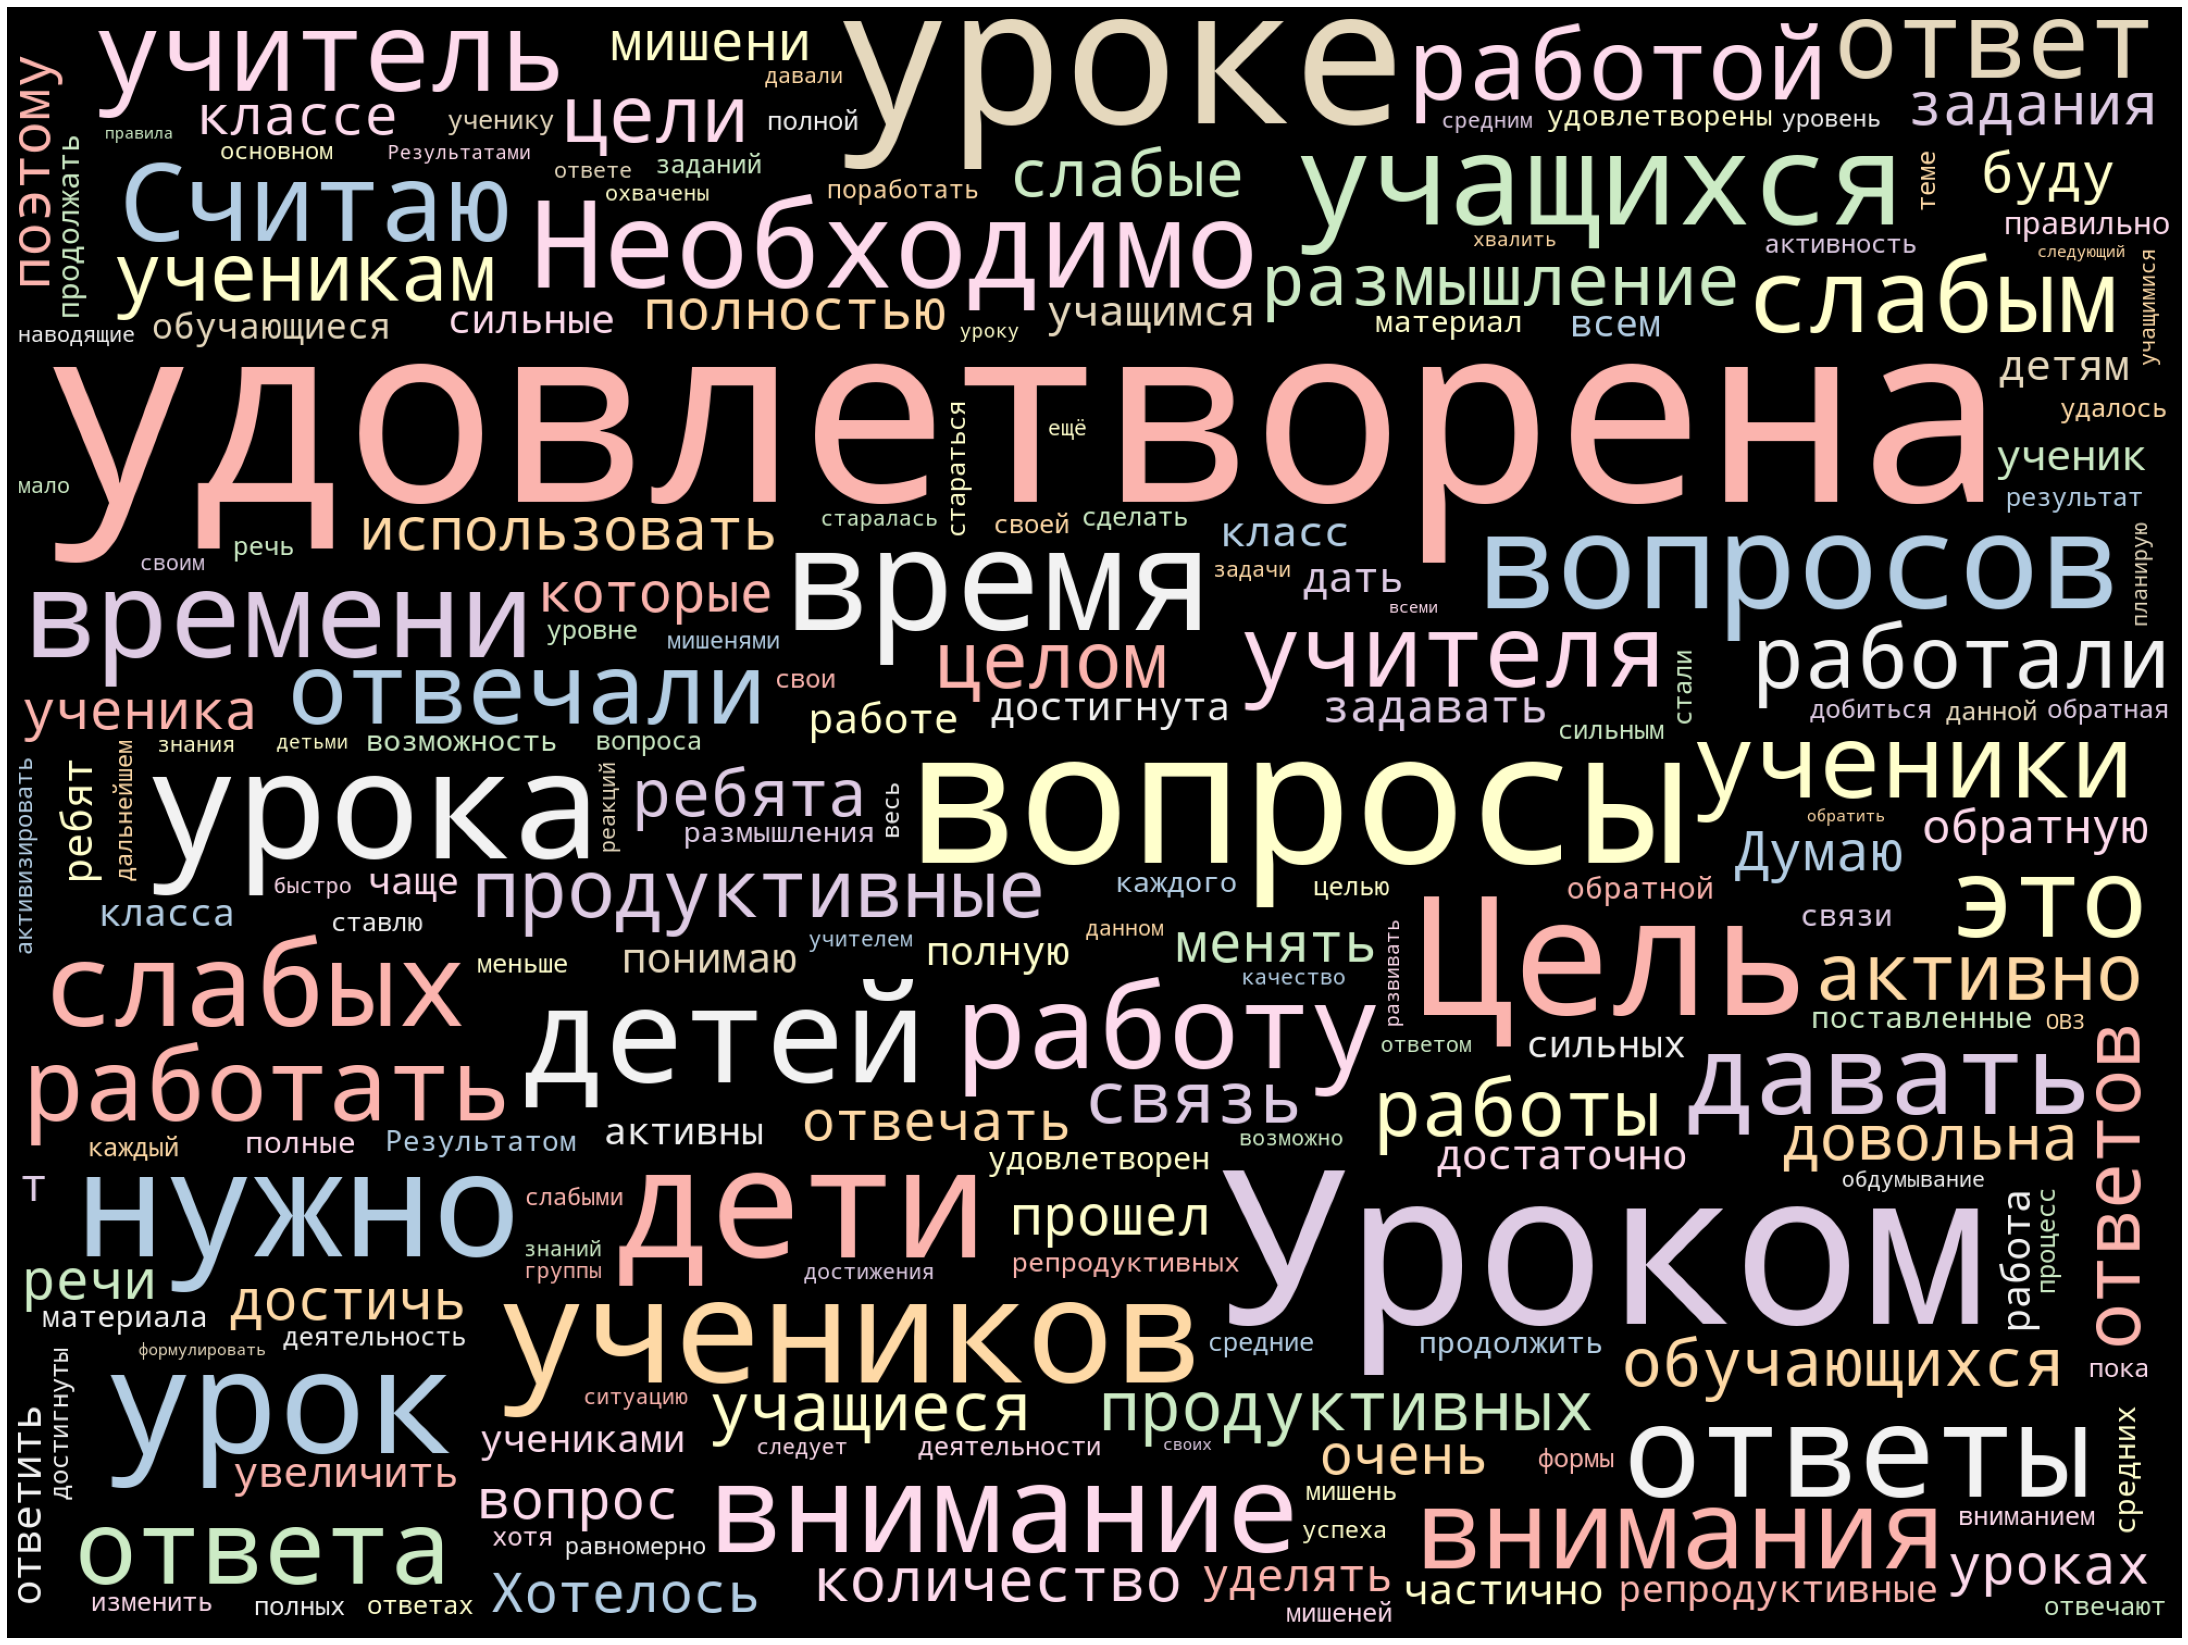

In [97]:
# Генерируем облако слов
wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=1, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False, 
                      stopwords = STOPWORDS_RU).generate(text)

# Рисуем картинку
plot_cloud(wordcloud)